# Example 002: Fitting SPS-BWS simulation data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix
from scipy.constants import c

## Simulation data example

This example features simulated wakefield data of the "Beam Wire Scanner" device.

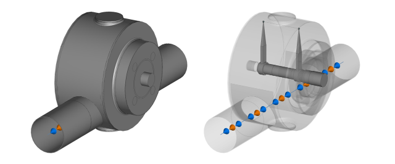

## Fitting on fully decayed wakefield

### Import data

In [2]:
# Importing impedance data
data = np.loadtxt(
    "examples/data/003_beam_wire_scanner.txt", comments="#", delimiter="\t"
)

# Extracting frequency and impedance

frequency = data[:, 0] * 1e9  # Convert to GHz
real_impedance = data[:, 1]
imag_impedance = data[:, 2]

impedance = real_impedance + 1j * imag_impedance

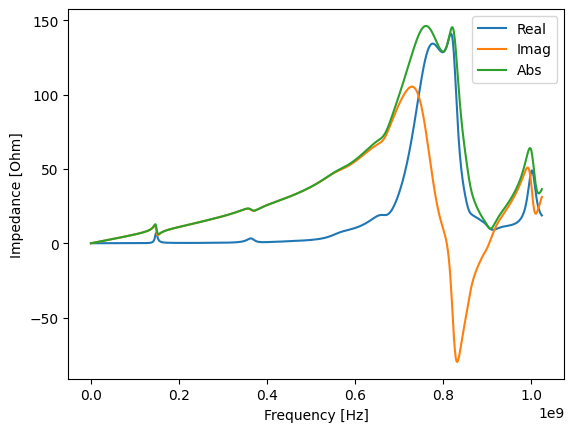

In [3]:
plt.plot(frequency, impedance.real, label="Real")
plt.plot(frequency, impedance.imag, label="Imag")
plt.plot(frequency, np.abs(impedance), label="Abs")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Impedance [Ohm]")
plt.legend()

For the beam wire scanner, the power loss due to the real part of the impedance is crucial. Thus this example will demonstrate fitting upon the real part, as opposed to the prior examples which fitted upon the absolute impedance magnitude

In [4]:
# Bounds on resonators parameters
""" In this example, we will use the SmartBoundDetermination class to determine the bounds on the resonators parameters. 
By using SmartBoundDetermination ther is no need to specify the bounds manually."""

SBD_parameterBound = iddefix.SmartBoundDetermination(
    frequency, impedance.real, minimum_peak_height=2
)

parameterBounds = SBD_parameterBound.find()

N_resonators = SBD_parameterBound.N_resonators

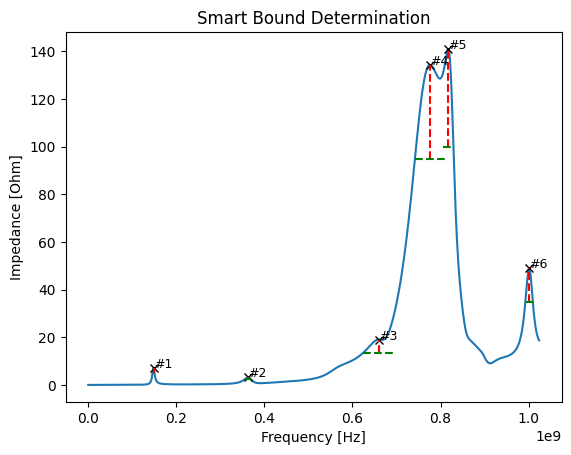

In [5]:
SBD_parameterBound.inspect()

In [6]:
SBD_parameterBound.to_table()


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |     5.64 to 70.54      | 36.25 to 362.50  |  1.38e+08 to 1.58e+08   
    2     |     2.61 to 32.61      | 14.79 to 147.92  |  3.53e+08 to 3.73e+08   
    3     |    15.23 to 190.40     |  4.48 to 44.79   |  6.50e+08 to 6.70e+08   
    4     |   107.43 to 1342.91    |  5.57 to 55.74   |  7.66e+08 to 7.86e+08   
    5     |   112.75 to 1409.35    | 18.14 to 181.36  |  8.07e+08 to 8.27e+08   
    6     |    39.21 to 490.08     | 30.56 to 305.62  |  9.91e+08 to 1.01e+09   
--------------------------------------------------------------------------------


#### Running IDDEFIX DE
Running the DE algorithm with IDDEFIX and chosen parameters.

In [7]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(
    frequency,
    impedance.real,
    N_resonators=N_resonators,
    parameterBounds=SBD_parameterBound.find(),
    plane="longitudinal",
    objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal,
)

DE_model.run_differential_evolution(
    maxiter=30000, popsize=90, tol=0.0001, mutation=(0.3, 0.8), crossover_rate=0.5
)
print(DE_model.warning)

[!] Using the fully decayed resonator formalism for impedance


Optimization Progress %:   0%|          | 0/100 [00:00<?, ?it/s]

Optimization Progress %: 103.64293394618171it [01:28,  1.18it/s]                              



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        9.00e+00        |      36.49       |    1.482e+08     
    2     |        2.96e+00        |      20.91       |    3.619e+08     
    3     |        1.52e+01        |      10.77       |    6.504e+08     
    4     |        1.28e+02        |      10.98       |    7.661e+08     
    5     |        1.13e+02        |      27.02       |    8.155e+08     
    6     |        4.32e+01        |      36.01       |    1.001e+09     
----------------------------------------------------------------------
callback function requested stop early
CPU times: user 55.6 s, sys: 4.3 s, total: 59.9 s
Wall time: 1min 28s


#### Minimization step
To further refine the solution obtained by the DE algorithm, a second optimization step is applied using the Nelder-Mead minimization algorithm.

In [8]:
DE_model.run_minimization_algorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        6.90e+00        |      21.74       |    1.483e+08     
    2     |        3.15e+00        |      31.27       |    3.618e+08     
    3     |        7.62e+00        |       6.62       |    6.292e+08     
    4     |        1.30e+02        |       9.84       |    7.687e+08     
    5     |        9.22e+01        |      28.56       |    8.164e+08     
    6     |        4.30e+01        |      38.31       |    1.001e+09     
----------------------------------------------------------------------


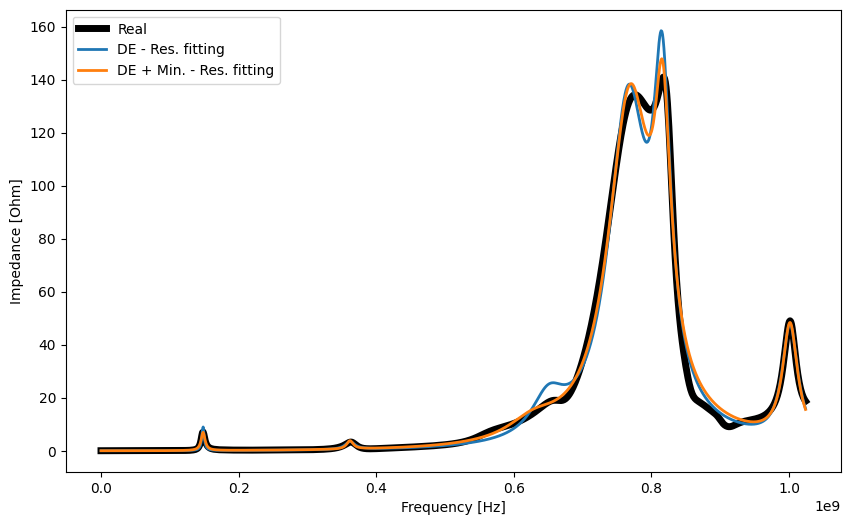

In [9]:
plt.figure(figsize=(10, 6))
result_DE = DE_model.get_impedance(use_minimization=False).real
result_DE_MIN = DE_model.get_impedance().real

plt.plot(frequency, impedance.real, lw=5, label="Real", color="black")
plt.plot(frequency, result_DE, lw=2, label="DE - Res. fitting")
plt.plot(frequency, result_DE_MIN, lw=2, label="DE + Min. - Res. fitting")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Impedance [Ohm]")
plt.legend()

And the wake too:

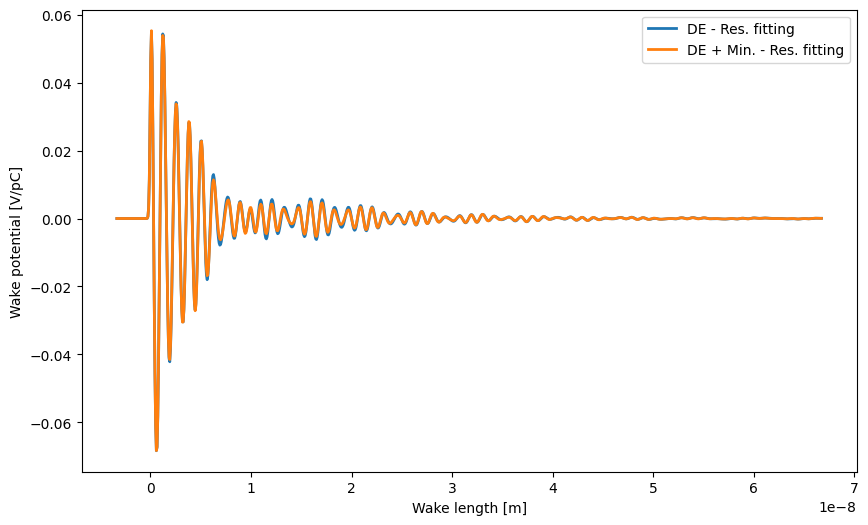

In [10]:
plt.figure(figsize=(10, 6))

timeframe = np.linspace(-1, 20, 1000) / c

result_DE = DE_model.get_wake_potential(timeframe, 1e-10, use_minimization=False) / 1e12
result_DE_MIN = DE_model.get_wake_potential(timeframe, sigma=1e-10) / 1e12

plt.plot(timeframe, result_DE, lw=2, label="DE - Res. fitting")
plt.plot(timeframe, result_DE_MIN, lw=2, label="DE + Min. - Res. fitting")
plt.xlabel("Wake length [m]")
plt.ylabel("Wake potential [V/pC]")
plt.legend()